# Data interaction

This notebook shows how an external user may interact with data being managed from GAIN pilot partner sites. 
It relies on a lightweight, publcily-available package, `pycloudmessenger` that allows interaction with
all data collected and generated (model generated, etc.) at GAIN pilot partner sites.



In [22]:
import os
import logging
import json
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
## castorapi allows us interface with the cloud server using appropriate credentials
import pycloudmessenger.castor.castorapi as castorapi

#Set up logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s.%(msecs)03d %(levelname)-6s %(name)s %(thread)d :: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')

LOGGER = logging.getLogger(__package__)


Interaction with the service is via an AMQP-based publish-subscribe protocol. Access is managed by a `credentials` file unique to each pilot partner site. This provides the cloud messenger service with `context` to interact securely with data stored in the cloud service (sensor data, weather data, model forecasts, etc.)

As an example we request a list of all available sensor observations for the GIFAS partner site using the `castor.request_sensor_list()` functionality.

In [23]:
# credentials file used to securely connect to the cloud server
cred_file = 'credentials.json'
context = castorapi.CastorContext.from_credentials_file(cred_file)
try:
    with castorapi.CastorMessenger(context) as castor:
        message = castor.request_sensor_list()
        reply = castor.invoke_service(message)
        LOGGER.info("\n\nAvailable Sensor IDs: " + str(reply['ts_ids']) + "\n")
except Exception as err:
    LOGGER.info("Error %r", err)
    
sensor_id = reply['ts_ids']


2019-10-07 16:28:17.285 INFO   root 4648375744 :: 

Available Sensor IDs: ['5300-669-oxygen_12m', '5300-669-oxygen_3m', '5300-669-salinity_6m', '5300-669-temp_12m', '5300-669-temp_3m', '5300-669-temp_6m', 'Barge_Temp_3m', 'CASTOR.TimeSeriesInsert', 'Feeding-Feed_end', 'Feeding-Feed_kg', 'Feeding-Feed_start', 'Lice-Average_chalimus', 'Lice-Average_matureFemale', 'Lice-Average_pre-adult', 'Mortality', 'RCM-currentspeed_m/s', 'RCM-depth_m', 'RCM-direction_deg', 'SmartGuard-oxygen_12m', 'SmartGuard-oxygen_3m', 'SmartGuard-salinity_6m', 'SmartGuard-temp_12m', 'SmartGuard-temp_3m', 'SmartGuard-temp_6m', 'TSO_SENSOR1.WATER_TEMPERATURE.test_model.12::74         ', 'Welfare-Fish_no', 'Welfare-Score_Condition', 'Welfare-Score_Deformity', 'Welfare-Score_EyeHealth', 'Welfare-Score_FinDamage', 'Welfare-Score_Gills', 'Welfare-Score_Haemorrhage', 'Welfare-Score_Maturation', 'Welfare-Score_Operculum', 'Welfare-Score_Overbite', 'Welfare-Score_ScaleLoss', 'Welfare-Score_Snout', 'Welfare-Score_Underbite'

The next step is to interogate specific sensor dataset. One can query a particular sensor dataset 
for a desired time_range using the 
`castor.request_sensor_data()` call. For this simple example we request data from the first two sensor
returned in the `sensor_id` list. Obviously, the user generally would request particular sensor based on id and defined context (i.e. what the sensor id refers to)  


In [17]:
def request_sensor_data(sensor: str, from_date: str, to_date: str):
    # Function requests data for user defined sensor id and 
    # date range 
        #Retrieve some time series
    LOGGER.info("Requesting time series for sensor ID '%s'...", sensor)
    message = castor.request_sensor_data(sensor,from_date,to_date)
    reply = castor.invoke_service(message)
    LOGGER.info("\n\nNumber of Time Series Values: %d", reply['count'])
    df = pd.DataFrame(reply['values'], 
                    columns=['Timestamp', 'SensorID', 'value','offset'])
    # Convert to pandas timestamp for visualisation
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])  
    df['label'] = sensor # add relevant label   
    return df

try:
    with castorapi.CastorMessenger(context) as castor:
        #List the devices
        LOGGER.info("Request sensor data from server")
        sensor_df1 = request_sensor_data(sensor_id[0], "2001-07-13T00:00:00+00:00",  "2020-08-13T01:00:00+00:00")
        sensor_df2 = request_sensor_data(sensor_id[1], "2001-07-13T00:00:00+00:00",  "2020-08-13T01:00:00+00:00")
except Exception as err:
    LOGGER.info("Error %r", err)


2019-10-07 16:25:46.227 INFO   root 4648375744 :: Request sensor data from server
2019-10-07 16:25:46.228 INFO   root 4648375744 :: Requesting time series for sensor ID '5300-669-oxygen_12m'...
2019-10-07 16:25:46.599 INFO   root 4648375744 :: 

Number of Time Series Values: 1132
2019-10-07 16:25:46.604 INFO   root 4648375744 :: Requesting time series for sensor ID '5300-669-oxygen_3m'...
2019-10-07 16:25:47.273 INFO   root 4648375744 :: 

Number of Time Series Values: 1132


,value
count,1132.000000
mean,111.611548
std,29.941946
min,62.548650
25%,96.452830
50%,103.469850
75%,117.739275
max,275.867100


### Finally, we create some elementary visualisations on the sensor data returned and compare measured temperature at multiple depths

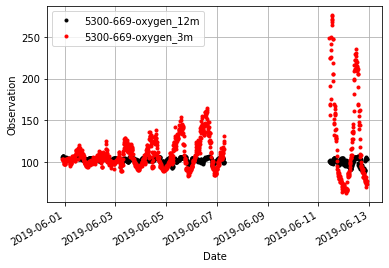

In [21]:
# plot and compare data,
fig, ax = plt.subplots()
plt.plot(sensor_df1['Timestamp'], sensor_df1['value'], 'k.', label = sensor_df1['label'][0])
plt.plot(sensor_df2['Timestamp'], sensor_df2['value'], 'r.', label = sensor_df2['label'][0])
plt.legend(loc='upper left')
# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # The interval here specifies the interval to which 
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_xlabel('Date')
ax.set_ylabel(r'Observation')
ax.grid()

